In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
# from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#BTC

##Step 1: Read Data

In [ ]:
# Read data
df = pd.read_csv('/content/BTC-USD-3.2018-3.2024.csv', parse_dates=['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-01,10385.000000,11052.299805,10352.700195,10951.000000,10951.000000,7317279744
1,2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,11086.400391,7620590080
2,2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,11489.700195,6690570240
3,2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,11512.599609,6084149760
4,2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,11573.299805,6468539904
...,...,...,...,...,...,...,...
2188,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,54522.402344,34074411896
2189,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,57085.371094,49756832031
2190,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,62504.789063,83239156760
2191,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,61198.382813,65496611844


##Step 2: Explore Data

In [ ]:
# Dataset Description
df = df.set_index('Date')
print(f"Dataset Shape: {df.shape}")
print(f"Dataset Info: {df.info()}")
print(f"Dataset Describe: {df.describe()}")

Dataset Shape: (2193, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2193 entries, 2018-03-01 to 2024-03-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2193 non-null   float64
 1   High       2193 non-null   float64
 2   Low        2193 non-null   float64
 3   Close      2193 non-null   float64
 4   Adj Close  2193 non-null   float64
 5   Volume     2193 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 119.9 KB
Dataset Info: None
Dataset Describe:                Open          High           Low         Close     Adj Close  \
count   2193.000000   2193.000000   2193.000000   2193.000000   2193.000000   
mean   22705.310922  23217.108536  22164.070169  22727.117088  22727.117088   
std    16415.707425  16828.247923  15967.197094  16431.977633  16431.977633   
min     3236.274658   3275.377930   3191.303467   3236.761719   3236.761719   
25%     8370.049805   8585.150391   8185.763184

##Step 3: Feature Engineering

In [ ]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)


    df['Close_Diff'] = df['Adj Close'].diff()

    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean()
    df['MA100'] = df['Close'].rolling(window=100).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['MA26'] = df['Close'].rolling(window=26).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA12'] = df['Close'].rolling(window=12).mean()

    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']

    # Moving Averages on high, lows, and std - different periods
    df['MA200_low'] = df['Low'].rolling(window=200).min()
    df['MA14_low'] = df['Low'].rolling(window=14).min()
    df['MA200_high'] = df['High'].rolling(window=200).max()
    df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std()

    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    df['Bollinger_Middle'] = df['MA20']

    # Relative Strength Index (RSI)
    df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    df['RSI'] = df['K-ratio'].rolling(window=3).mean()

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']

    # Replace nas
    nareplace = df.at[df.index.max(), 'Close']
    df.fillna((nareplace), inplace=True)

    #
    return df

                  Close       MACD        RSI  Bollinger_Upper  Bollinger_Lower         MA26        EMA20    K-ratio
Date                                                                                                                
2018-10-02  6556.100098 -10.684094  63.027742      6792.186134      6313.780956  6502.164645  6584.695354  57.365334
2018-10-03  6502.589844 -16.371112  49.387182      6792.002241      6312.492828  6503.530799  6576.875781  27.901531
2018-10-04  6576.689941 -14.729068  43.431147      6794.686803      6316.206264  6517.019644  6576.858082  45.026575
2018-10-05  6622.479980  -9.621947  42.845692      6800.417097      6318.403948  6529.389648  6581.203025  55.608969
2018-10-06  6588.310059  -8.236796  50.614096      6803.448380      6322.485653  6539.336182  6581.879885  51.206746
                  Close       MACD        RSI  Bollinger_Upper  Bollinger_Lower         MA26        EMA20    K-ratio
Date                                                            

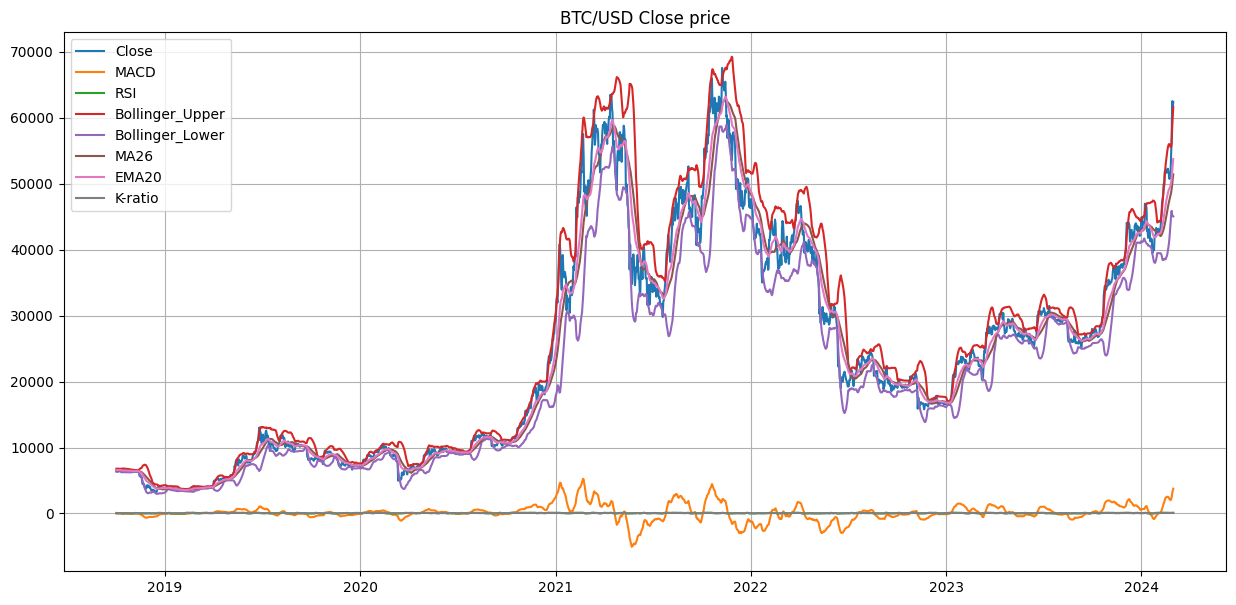

In [ ]:
# List of considered Features
FEATURES = [
            # 'High',
            # 'Low',
            # 'Open',
            'Close',
            # 'Volume',
#             'Day',
#             'Month',
#             'Year',
            # 'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
            'MACD',
            'RSI',
            # 'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
            # 'MA100',
#             'MA50',
            'MA26',
#             'MA14_low',
#             'MA14_high',
            # 'MA12',
            'EMA20',
            # 'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE',
            # 'MA20dSTD',
            # 'Close_Diff',
            'K-ratio'
           ]

# Create the dataset with features
df_features = createFeatures(df)

# Shift the timeframe by 10 month -> Start date is 2010-11-01
use_start_date = pd.to_datetime("2018-10-01")
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
df_filtered = df_features[FEATURES].copy()

# Filter the data to the list of FEATURES
print(df_filtered.head().to_string())

# # Create the lag of FEATURES (1 day before)
# for feature in FEATURES:
#    # drop the original feature except for the close price
#     if feature != 'Close':
#         df_filtered[feature + '_lag1'] = df_filtered[feature].shift(1)
#         df_filtered.drop(feature, axis=1, inplace=True)




# Filter the data to the list of FEATURES
df_filtered = df_filtered.dropna()
print(df_filtered.head().to_string())
df=df_filtered
# Create the lineplot
plt.figure(figsize=(15, 7))
plt.plot(df_filtered)
plt.title('BTC/USD Close price')
plt.grid()
plt.legend(df_filtered.columns)
plt.show()


##Step 4: Testing Causation using Granger’s Causality Test

In [ ]:
# The basis behind Vector AutoRegression is that each of the time series in the
# system influences each other. That is, you can predict the series with past
# values of itself along with other series in the system.

# Using Granger’s Causality Test, it’s possible to test this relationship before
# even building the model.

# Ho: past values of time series (X) DO NOT cause the other series (Y).

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=24
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,Close_x,MACD_x,RSI_x,Bollinger_Upper_x,Bollinger_Lower_x,MA26_x,EMA20_x,K-ratio_x
Close_y,1.0000,0.0877,0.0989,0.0000,0.0000,0.0000,0.1380,0.0959
MACD_y,0.1652,1.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0000
RSI_y,0.0000,0.0000,1.0000,0.0608,0.0032,0.0000,0.0000,0.0000
Bollinger_Upper_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
Bollinger_Lower_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
MA26_y,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
EMA20_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
K-ratio_y,0.2041,0.1385,0.1332,0.1839,0.2033,0.1439,0.2737,1.0000


##Step 5: Train & Test split

In [ ]:
# Train-Validation-Test Split
def split_data(df, test_size=None, valid_size=None):
    ntest = int(len(df)*test_size)
    nvalid = int(len(df)*valid_size)
    ntrain = len(df) - ntest - nvalid
    train = df.iloc[:ntrain].copy()
    valid = df.iloc[ntrain:ntrain+nvalid].copy()
    test = df.iloc[ntrain+nvalid:].copy()
    return train, valid, test

# Split the data
train, valid, test = split_data(df_filtered, valid_size=0.25, test_size=0.1)


In [ ]:
print(train.shape, valid.shape, test.shape)

(1287, 8) (494, 8) (197, 8)


##Step 6: Model Specification

**VAR**

**1. Check for stationary**

In [ ]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag='AIC', regression='ct')
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    # print("1. ADF : ",dftest[0])
    # Print dataset cols
    # print("3. Num Of Lags : ", dftest[2])
    # print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    # # print("5. Critical Values :")
    # for key, val in dftest[4].items():
    #    print("\t",key, ": ", val)
    if (dftest[0] < dftest[4]["5%"] or dftest[0] < dftest[4]["1%"] or dftest[0] < dftest[4]["10%"]):
        print ("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print ("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False


In [ ]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*"*50 + f" Differencing of order {diff_order} " + "*"*50)
    train_diff = pd.DataFrame(np.diff(train, diff_order, axis=0), columns=train.columns)
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'Close' -> p-value: 0.532
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'MACD' -> p-value: 0.006
Reject Ho - Time Series is Stationary
ADF Test on 'RSI' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'Bollinger_Upper' -> p-value: 0.599
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'Bollinger_Lower' -> p-value: 0.329
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'MA26' -> p-value: 0.357
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'EMA20' -> p-value: 0.233
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'K-ratio' -> p-value: 0.000
Reject Ho - Time Series is Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'Close' -> p-value: 0.000
Reject Ho - Ti

**2. Select the order (P) of VAR model**

In [ ]:
train_diff[['Close', 'MACD', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower',	'MA26',	'EMA20','K-ratio']]

,Close,MACD,RSI,Bollinger_Upper,Bollinger_Lower,MA26,EMA20,K-ratio
0,-53.510254,-5.687017,-13.640560,-0.183893,-1.288128,1.366155,-7.819572,-29.463803
1,74.100097,1.642044,-5.956035,2.684562,3.713436,13.488845,-0.017699,17.125044
2,45.790039,5.107121,-0.585455,5.730294,2.197684,12.370005,4.344943,10.582394
3,-34.169921,1.385152,7.768405,3.031284,4.081705,9.946533,0.676860,-4.402223
4,14.640136,2.346973,3.270476,-23.486150,55.661150,10.836538,2.006696,3.631257
...,...,...,...,...,...,...,...,...
1281,-2349.253907,-297.390438,-23.006629,-154.469725,380.005663,169.683293,-139.452375,-50.276449
1282,297.109375,-222.573022,-22.615293,-86.618487,256.887627,176.916767,-97.875066,2.678711
1283,-1216.183593,-282.137471,-19.157753,-7.436936,17.138108,170.692308,-204.380640,-9.875519
1284,494.472656,-189.126926,0.393195,-144.800885,298.232135,119.822416,-137.823183,8.376392


In [ ]:
model = VAR(train_diff)
sorted_order = model.select_order(maxlags=7)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       73.43       73.46   7.767e+31       73.44
1      22.15*      22.44*  4.169e+09*      22.26*
2       26.11       26.66   2.182e+11       26.31
3       30.65       31.45   2.042e+13       30.95
4       31.31       32.37   3.965e+13       31.71
5       31.56       32.89   5.110e+13       32.06
6       29.27       30.85   5.154e+12       29.86
7       31.09       32.92   3.171e+13       31.78
-------------------------------------------------


In [ ]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, May, 2024
Time:                     12:45:03
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    26.2845
Nobs:                     1284.00    HQIC:                   25.9433
Log likelihood:          -30963.3    FPE:                1.50647e+11
AIC:                      25.7382    Det(Omega_mle):     1.35601e+11
--------------------------------------------------------------------
Results for equation Close
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            22.563947        31.760157            0.710           0.477
L1.Close             -1566897057391.037842              NAN              NAN             NAN
L1.MACD     

In [ ]:
# statsmodels.tsa.statespace.varmax.VARMAX
from statsmodels.tsa.statespace.varmax import VARMAX

model = VARMAX(train_diff, order=(1, 0), trend='c')
fitted = model.fit(disp=False)
print(fitted.summary())


                                                               Statespace Model Results                                                               
Dep. Variable:     ['Close', 'MACD', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'MA26', 'EMA20', 'K-ratio']   No. Observations:                 1286
Model:                                                                                                 VAR(1)   Log Likelihood              -42429.338
                                                                                                  + intercept   AIC                          85074.676
Date:                                                                                        Mon, 06 May 2024   BIC                          85631.879
Time:                                                                                                12:57:45   HQIC                         85283.853
Sample:                                                                                       

**4. Check for remaining serial correlation**

Serial correlation of residuals is used to check if there is any leftover pattern
in the residuals (errors). If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.
A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic.

The value of this statistic can vary between 0 and 4. The closer it is to the value = 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Close : 2.0
MACD : 2.0
RSI : 2.0
Bollinger_Upper : 2.01
Bollinger_Lower : 2.01
MA26 : 2.03
EMA20 : 2.0
K-ratio : 2.0


**5. Forecasting**

In [ ]:
n_forecast = len(valid)
forecast = fitted.predict(start=len(train), end=len(train) + n_forecast - 1)
Forecast = pd.DataFrame(forecast)
Forecast.index = valid.index

In [ ]:
# Take the last row of the training dataframe to start the inversion
initial_value = train.iloc[-1]

# Invert differencing
valid_df_inverted = Forecast.cumsum() + initial_value
valid_df_inverted

,Close,MACD,RSI,Bollinger_Upper,Bollinger_Lower,MA26,EMA20,K-ratio
Date,,,,,,,,
2022-04-11,42142.746024,135.948124,5.333841,48365.111875,41255.565170,44122.666596,43751.313796,4.916050
2022-04-12,42094.663667,26.823631,6.536589,48208.408132,41284.498834,44176.361862,43601.432725,6.547133
2022-04-13,42062.865184,-58.768009,8.108969,48047.813964,41268.930910,44209.426729,43462.922570,8.108214
2022-04-14,42045.405530,-123.723610,9.829101,47885.517068,41220.775955,44222.758922,43336.065802,9.622397
2022-04-15,42039.815595,-170.758262,11.581164,47724.110352,41149.816191,44218.023701,43220.882861,11.075900
...,...,...,...,...,...,...,...,...
2023-08-13,55293.375636,509.051205,9.364174,61010.023301,51985.440256,56101.292843,55735.528810,4.979956
2023-08-14,55321.097702,509.270648,9.319046,61042.467991,52012.542895,56130.488751,55764.551931,4.937709
2023-08-15,55348.819768,509.490090,9.273919,61074.912681,52039.645534,56159.684660,55793.575052,4.895462


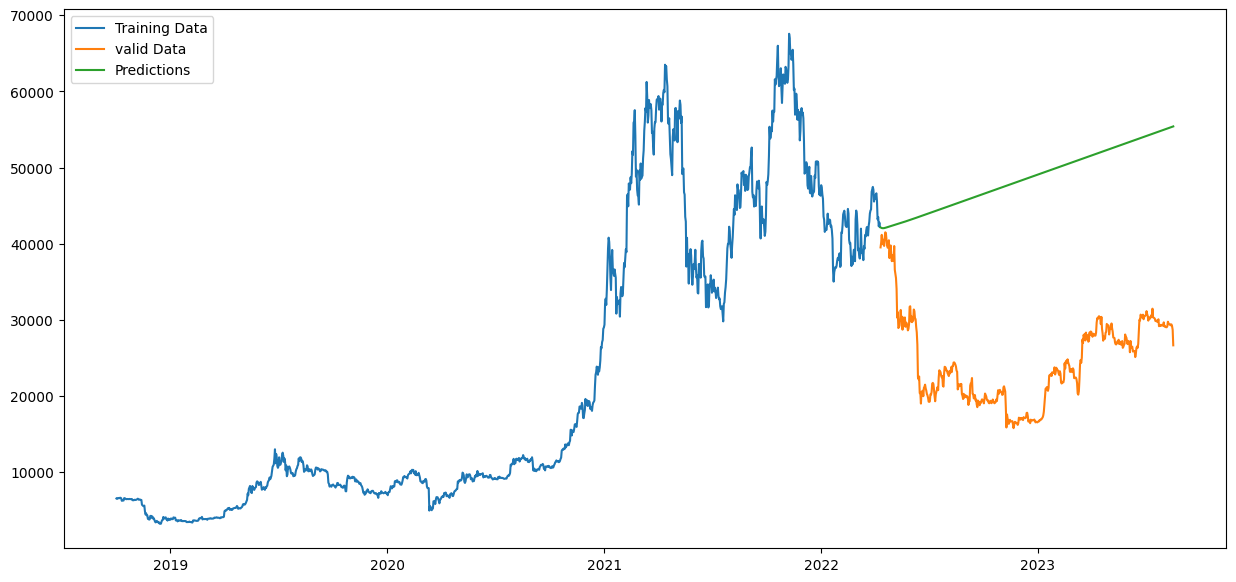

In [ ]:
# Plot overall
plt.figure(figsize=(15, 7))
plt.plot(train['Close'], label='Training Data')
plt.plot(valid['Close'], label='valid Data')
plt.plot(valid_df_inverted['Close'], label='Predictions')
plt.legend(loc='upper left')
plt.show()


**4. Check stable data**

**5. Impulse Response Test**

**6. Variance Decomposition**